## Grid Search for Hyperparameters - by Yating Jing

From previous experiments, LLE pipelined with QDA in a gender-distinguished manner gave the best prediction result on the task of separating ADHD and Bipolar disorders. 

This notebook focuses on selecting the best hyperparameters for LLE, SVM and Random Forest using Grid Search method.

In [1]:
import pandas as pd
import numpy as np

df_adhd = pd.read_csv('ADHD_Gender_rCBF.csv')
df_bipolar = pd.read_csv('Bipolar_Gender_rCBF.csv')

n1, n2 = df_adhd.shape[0], df_bipolar.shape[0]

print 'Number of ADHD patients (without Bipolar) is', n1
print 'Number of Bipolar patients (without ADHD) is', n2
print 'Chance before gender separation is', float(n1) / (n1 + n2)

Number of ADHD patients (without Bipolar) is 1484
Number of Bipolar patients (without ADHD) is 471
Chance before gender separation is 0.759079283887


In [2]:
# Separate the genders
adhd1_id, adhd2_id = list(), list()
bipolar1_id, bipolar2_id = list(), list()

for i, g in df_adhd[['Patient_ID', 'Gender_id']].values:
    if g == 1:
        adhd1_id.append(i)
    elif g == 2:
        adhd2_id.append(i)
        
for i, g in df_bipolar[['Patient_ID', 'Gender_id']].values:
    if g == 1:
        bipolar1_id.append(i)
    elif g == 2:
        bipolar2_id.append(i)
        
print 'Number of Gender 1 ADHD patients (without Bipolar) is', len(adhd1_id)
print 'Number of Gender 2 ADHD patients (without Bipolar) is', len(adhd2_id)
print 'Number of Gender 1 Bipolar patients (without ADHD) is', len(bipolar1_id)
print 'Number of Gender 2 Bipolar patients (without ADHD) is', len(bipolar2_id)

Number of Gender 1 ADHD patients (without Bipolar) is 1017
Number of Gender 2 ADHD patients (without Bipolar) is 467
Number of Gender 1 Bipolar patients (without ADHD) is 242
Number of Gender 2 Bipolar patients (without ADHD) is 228


In [3]:
# Separate ADHD data gender-wise
df_adhd1 = df_adhd.loc[df_adhd['Patient_ID'].isin(adhd1_id)].drop(['Patient_ID', 'Gender_id'], axis=1)
df_adhd2 = df_adhd.loc[df_adhd['Patient_ID'].isin(adhd2_id)].drop(['Patient_ID', 'Gender_id'], axis=1)
# Separate Bipolar data gender-wise
df_bipolar1 = df_bipolar.loc[df_bipolar['Patient_ID'].isin(bipolar1_id)].drop(['Patient_ID', 'Gender_id'], axis=1)
df_bipolar2 = df_bipolar.loc[df_bipolar['Patient_ID'].isin(bipolar2_id)].drop(['Patient_ID', 'Gender_id'], axis=1)

# Create disorder labels for classification
# ADHD: 0, Bipolar: 1
n1_adhd, n1_bipolar = len(adhd1_id), len(bipolar1_id)
n2_adhd, n2_bipolar = len(adhd2_id), len(bipolar2_id)
# Labels for gender 1
y1 = [0] * n1_adhd + [1] * n1_bipolar  
# Labels for gender 2
y2 = [0] * n2_adhd + [1] * n2_bipolar 

print 'Shape check:'
print 'ADHD:', df_adhd1.shape, df_adhd2.shape
print 'Bipolar:', df_bipolar1.shape, df_bipolar2.shape

# Gender1 data
df1_all = pd.concat([df_adhd1, df_bipolar1], axis=0)
# Gender2 data
df2_all = pd.concat([df_adhd2, df_bipolar2], axis=0)

print '\nDouble shape check:'
print 'Gender 1:', df1_all.shape, len(y1)
print 'Gender 2:', df2_all.shape, len(y2)

# Compute chances 
chance1 = float(n1_adhd)/(n1_adhd + n1_bipolar)
chance2 = float(n2_adhd)/(n2_adhd + n2_bipolar)
print 'Chance for gender 1 is', chance1
print 'Chance for gender 2 is', chance2

Shape check:
ADHD: (1017, 256) (467, 256)
Bipolar: (242, 256) (228, 256)

Double shape check:
Gender 1: (1259, 256) 1259
Gender 2: (695, 256) 695
Chance for gender 1 is 0.80778395552
Chance for gender 2 is 0.671942446043


### Dimensionality Reduction - Classification Pipeline

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.grid_search import GridSearchCV
from sklearn.qda import QDA
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold

def lle_clf_pipe(X, y, gender, n_feats, k=10):
    '''
    Train and test an LLE - Classifier Pipeline
    Args:
        X: training data (2D numpy matrix)
        y: labels (1D vector)
        gender: current gender genre (for plotting)
        n_feats: number of features used in classification
        k: number of folds (default=10)
    '''
    
    lle = LocallyLinearEmbedding(n_components=n_feats)
    qda = QDA()
    svc = svm.SVC()
    rf = RandomForestClassifier() 
    
    pipe_qda = Pipeline(steps=[('lle', lle), ('qda', qda)])
    pipe_svc = Pipeline(steps=[('lle', lle), ('svc', svc)])
    pipe_rf = Pipeline(steps=[('lle', lle), ('rf', rf)])
    
    X_all, y_all = np.array(X), np.array(y)
    kf = KFold(len(X), n_folds=k)
    scores_qda, scores_svm, scores_rf = [], [], []

    for i, (train_index, test_index) in enumerate(kf):
        print 'Fold ' + str(i) + ':',
        
        # Train test split
        X_train, X_test = X_all[train_index], X_all[test_index]
        y_train, y_test = y_all[train_index], y_all[test_index]
        
        
        ############################ QDA ############################
        
        grid_qda = GridSearchCV(pipe_qda,
                                dict(lle__n_neighbors=[25, 30],
                                     lle__method=['ltsa']))
        grid_qda.fit(X_train, y_train)
        best_est_qda = grid_qda.best_estimator_
        
        score_qda = best_est_qda.score(X_test, y_test)
        scores_qda.append(score_qda)
        
        print 'QDA accuracy is', score_qda
        
        
        ############################ SVM ############################
        
        grid_svm = GridSearchCV(pipe_svc,
                                dict(lle__n_neighbors=[25, 30],
                                     lle__method=['modified', 'ltsa'],
                                     svc__kernel=('linear', 'rbf'),
                                     svc__C=[1, 5, 10]))
        
        grid_svm.fit(X_train, y_train)
        best_est_svm = grid_svm.best_estimator_
        
        score_svm = best_est_svm.score(X_test, y_test)
        scores_svm.append(score_svm)
        
        print '        SVM accuracy is', score_svm
        
        
        ############################ Random Forest ############################
        
        # grid_search_estimator = GridSearchCV(pipe,
        #                          dict(lle__n_neighbors=[20, 25, 30],
        #                               lle__eigen_solver=['auto', 'arpack', 'dense'],
        #                               lle__method=['standard', 'hessian', 'modified', 'ltsa'],
        #                               lle__neighbors_algorithm=['kd_tree', 'ball_tree'],
        #                               rf__criterion=('gini', 'entropy'),
        #                               rf__max_features=['sqrt', 'log2', None],
        #                               rf__min_samples_leaf=[1, 3, 5],
        #                               rf__bootstrap=[True, False]))
        
        grid_rf = GridSearchCV(pipe_rf,
                               dict(lle__n_neighbors=[25, 30],
                                    lle__method=['modified', 'ltsa'],
                                    rf__criterion=('gini', 'entropy'),
                                    rf__max_features=['sqrt', 'log2', None],
                                    rf__bootstrap=[True, False]))

        grid_rf.fit(X_train, y_train)
        best_est_rf = grid_rf.best_estimator_
        
        score_rf = best_est_rf.score(X_test, y_test)
        scores_rf.append(score_rf)
        
        print '        Random Forest accuracy is', score_rf
        
        
    scores_qda = np.array(scores_qda)
    scores_svm = np.array(scores_svm)
    scores_rf = np.array(scores_rf)
    scores = [scores_qda, scores_svm, scores_rf]
    
    clf_names = ['QDA', 'SVM', 'Random Forest']
    accs = []
    
    print '\n'
    for clf_name, scores in zip(clf_names, scores):
        acc, acc_std = scores.mean(), scores.std()
        accs.append(acc)
        print clf_name + ' accuracy is %0.4f (+/- %0.3f)' % (acc, acc_std)
        
    # Visualize classifier performance
    x = range(len(accs))
    width = 0.1/0.3
    plt.bar(x, accs, width)
    
    # Compute chance
    n0, n1 = y.count(0), y.count(1)
    chance = max(n0, n1) / float(n0 + n1)
    print 'Chance is', chance
    
    fig_title = gender + ' Classifier Performance on ' + 'LLE features'
    plt.title(fig_title, y=1.08)
    plt.xticks(x, clf_names, rotation=50)
    plt.xlabel('Classifier')
    plt.gca().xaxis.set_label_coords(1.1, -0.025)
    plt.ylabel('Accuracy')
    plt.axhline(chance, color='red', linestyle='--', label='chance') # plot chance
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.85))

## Gender 1 ADHD v.s. Bipolar Analysis

Gender 1 Analysis using LLE features:

Fold 0: QDA accuracy is 0.00793650793651
        SVM accuracy is 1.0
        Random Forest accuracy is 0.97619047619
Fold 1: QDA accuracy is 0.992063492063
        SVM accuracy is 1.0
        Random Forest accuracy is 0.97619047619
Fold 2: QDA accuracy is 1.0
        SVM accuracy is 1.0
        Random Forest accuracy is 0.984126984127
Fold 3: QDA accuracy is 1.0
        SVM accuracy is 1.0
        Random Forest accuracy is 0.97619047619
Fold 4: QDA accuracy is 0.992063492063
        SVM accuracy is 1.0
        Random Forest accuracy is 0.968253968254
Fold 5: QDA accuracy is 1.0
        SVM accuracy is 1.0
        Random Forest accuracy is 0.968253968254
Fold 6: QDA accuracy is 0.992063492063
        SVM accuracy is 1.0
        Random Forest accuracy is 0.968253968254
Fold 7: QDA accuracy is 1.0
        SVM accuracy is 1.0
        Random Forest accuracy is 0.984126984127
Fold 8: QDA accuracy is 0.920634920635
        SVM accuracy is 0.0714285714286

/Library/Python/2.7/site-packages/sklearn/qda.py:124: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


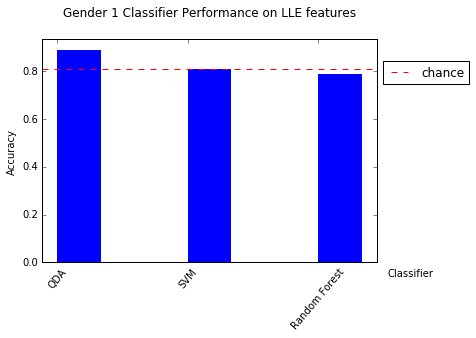

In [5]:
print 'Gender 1 Analysis using LLE features:\n'
X1 = df1_all.values
lle_clf_pipe(X1, y1, 'Gender 1', 15, k=10)

## Gender 2 ADHD v.s. Bipolar Analysis

Gender 2 Analysis using LLE features:

Fold 0: QDA accuracy is 1.0
        SVM accuracy is 1.0
        Random Forest accuracy is 0.828571428571
Fold 1: QDA accuracy is 1.0
        SVM accuracy is 1.0
        Random Forest accuracy is 0.785714285714
Fold 2: QDA accuracy is 1.0
        SVM accuracy is 1.0
        Random Forest accuracy is 0.8
Fold 3: QDA accuracy is 1.0
        SVM accuracy is 1.0
        Random Forest accuracy is 0.742857142857
Fold 4: QDA accuracy is 1.0
        SVM accuracy is 1.0
        Random Forest accuracy is 0.742857142857
Fold 5: QDA accuracy is 1.0
        SVM accuracy is 1.0
        Random Forest accuracy is 0.811594202899
Fold 6: QDA accuracy is 0.695652173913
        SVM accuracy is 0.695652173913
        Random Forest accuracy is 0.652173913043
Fold 7: QDA accuracy is 0.0289855072464
        SVM accuracy is 0.0
        Random Forest accuracy is 0.0579710144928
Fold 8: QDA accuracy is 0.0144927536232
        SVM accuracy is 0.0
        Random Forest accurac

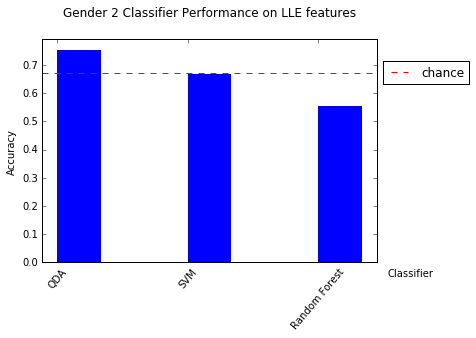

In [6]:
print 'Gender 2 Analysis using LLE features:\n'
X2 = df2_all.values
lle_clf_pipe(X2, y2, 'Gender 2', 15, k=10)

### Conclusion

Using grid search to select the best hyperparameters fails to improve the performance of SVM and Random Forest (still not better than chance). Moreover, for QDA, tuning LLE hyperparameters in each fold does not do better than fixing the hyperparameters then train and test the LLE-QDA pipeline directly, as shown in the [previous analysis](https://github.com/Upward-Spiral-Science/spect-team/blob/master/Code/Assignment-10/GenderDistinguished_ADHD_Bipolar_Fix&Tune_YatingJing.ipynb).